<a href="https://colab.research.google.com/github/BBotond03/SkinCancerDetection/blob/main/main_transfer_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Script for Downloading the Data
1. We download the data  through the Kaggle API (for this we will have to provide out personal API key, this can be found at Kaggle profile settings).
2. Extract the downloaded zip file

In [25]:
#to be able to download the dataset to our current runtime
!pip install kaggle

In [26]:
from google.colab import files

# Upload the file
uploaded = files.upload()

# Get the actual file name from the dictionary
file_name = list(uploaded.keys())[0]
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Save the API key securely without displaying it
with open('/root/.kaggle/kaggle.json', 'wb') as f:
    f.write(uploaded[file_name])

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json


Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [27]:
!kaggle competitions download -c isic-2024-challenge

isic-2024-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)


In [28]:
import zipfile
import os

# Path to your zip file and extract location
zip_file_path = 'isic-2024-challenge.zip'
extract_to_path = 'data'

# Extracting the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)
    print("Extraction completed.")

Extraction completed.


# Data Preproccessing

In [29]:
!pip install tensorflow

In [30]:
#neccesary imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import tensorflow_datasets as tfds
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample


In [31]:
import os
import pandas as pd
import cv2
import albumentations as A
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.utils import resample

# Load CSV
csv_path = './data/train-metadata.csv'
df = pd.read_csv(csv_path, low_memory=False)

# Append '.jpg' to each isic_id to match image filenames
df['isic_id'] = df['isic_id'].astype(str) + '.jpg'

# Directory where images are stored
img_dir = './data/train-image/image'  # Ensure this path is correct

# Filter for files that actually exist
df['filepath'] = df['isic_id'].apply(lambda x: os.path.join(img_dir, x))
df = df[df['filepath'].apply(os.path.exists)]

# Print out a summary
print(f"Number of valid images after filtering: {len(df)}")
print(df[['isic_id', 'filepath']].head())  # Optional: to verify paths

df['target'] = df['target'].astype(int)


print("Class Distribution Before Sampling (%):")
display(df.target.value_counts(normalize=True)*100)

# Undersample the majority class to balance the dataset
df_majority = df.query("target==0").sample(frac=0.01, random_state=42)
df_minority = df.query("target==1").sample(frac=5.0, replace=True, random_state=42)
df = pd.concat([df_majority, df_minority], axis=0).sample(frac=1.0)

print("\nCalss Distribution After Sampling (%):")
display(df.target.value_counts(normalize=True)*100)

Number of valid images after filtering: 401059
            isic_id                                   filepath
0  ISIC_0015670.jpg  ./data/train-image/image/ISIC_0015670.jpg
1  ISIC_0015845.jpg  ./data/train-image/image/ISIC_0015845.jpg
2  ISIC_0015864.jpg  ./data/train-image/image/ISIC_0015864.jpg
3  ISIC_0015902.jpg  ./data/train-image/image/ISIC_0015902.jpg
4  ISIC_0024200.jpg  ./data/train-image/image/ISIC_0024200.jpg
Class Distribution Before Sampling (%):


,proportion
target,
0,99.902009
1,0.097991



Calss Distribution After Sampling (%):


,proportion
target,
0,67.09645
1,32.90355


In [32]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


# Assume df is your DataFrame and 'target' is the column with class labels
class_weights = compute_class_weight('balanced', classes=np.unique(df['target']), y=df['target'])
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 0.7451959071624656, 1: 1.519592875318066}


In [33]:
# Data split
from sklearn.model_selection import StratifiedGroupKFold

df = df.reset_index(drop=True) # ensure continuous index
df["fold"] = -1
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
for i, (training_idx, validation_idx) in enumerate(sgkf.split(df, y=df.target, groups=df.patient_id)):
    df.loc[validation_idx, "fold"] = int(i)

# Use first fold for training and validation
training_df = df.query("fold!=0")
validation_df = df.query("fold==0")
print(f"# Num Train: {len(training_df)} | Num Valid: {len(validation_df)}")

# Num Train: 4706 | Num Valid: 1266


In [34]:
!pip install albumentations

In [35]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import numpy as np
import cv2
import tensorflow as tf
import math

# Define image size and batch size
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# Define the augmentation pipeline
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomResizedCrop(width=IMG_SIZE[0], height=IMG_SIZE[1], scale=(0.8, 1.0), p=1),  # Fixed scale
    A.CLAHE(p=0.5),  # Contrast Limited Adaptive Histogram Equalization
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=20, p=0.5),
    # A.GaussianBlur(blur_limit=3, p=0.3),
    # ToTensorV2()  # Convert the image to a PyTorch Tensor
])

class AlbumentationsImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size, img_size, aug=None, shuffle=True):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.img_size = img_size
        self.aug = aug
        self.shuffle = shuffle
        self.image_paths = dataframe['filepath'].values
        self.labels = dataframe['target'].values
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()  # Shuffle indexes if needed at initialization

    def __len__(self):
        # Return the total number of batches per epoch
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        # Shuffle the indexes after each epoch if required
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        # Ensure index is valid and within range
        if index >= len(self):
            raise IndexError(f"Index {index} is out of bounds for dataset with {len(self)} batches.")

        # Get the range for this batch
        start_index = index * self.batch_size
        end_index = min((index + 1) * self.batch_size, len(self.image_paths))
        batch_indexes = self.indexes[start_index:end_index]

        # Prepare batch data
        batch_images = []
        batch_labels = self.labels[batch_indexes]

        for idx in batch_indexes:
            # Load image
            image = cv2.imread(self.image_paths[idx])
            if image is None:
                print(f"Warning: Failed to load image at {self.image_paths[idx]} (Index {idx})")
                continue

            # Convert BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Apply augmentations
            if self.aug:
                try:
                    image = self.aug(image=image)['image']
                except Exception as e:
                    print(f"Error during augmentation for {self.image_paths[idx]}: {e}")
                    continue

            # Resize the image
            try:
                image = cv2.resize(image, (self.img_size[0], self.img_size[1]))
            except Exception as e:
                print(f"Error resizing image at {self.image_paths[idx]}: {e}")
                continue

            # Add to batch
            batch_images.append(image)

        # Normalize the images and convert to NumPy array
        batch_images = np.array(batch_images) / 255.0  # Scale to [0, 1]

        # Ensure batch isn't empty
        if len(batch_images) == 0:
            print(f"Empty batch at index {index}. Skipping to next batch.")
            return self.__getitem__((index + 1) % len(self))

        return batch_images, batch_labels


train_gen = AlbumentationsImageGenerator(
    dataframe=training_df,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    aug=aug
)

val_gen = AlbumentationsImageGenerator(
    dataframe=validation_df,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    aug=None,  # No augmentations for validation
    shuffle=False
)

# Generator wrapper
def train_gen_callable():
    for i in range(len(train_gen)):
        yield train_gen[i]

def val_gen_callable():
    for i in range(len(val_gen)):
        yield val_gen[i]

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_generator(
    train_gen_callable,
    output_signature=(
        tf.TensorSpec(shape=(None, *IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
).repeat()

val_dataset = tf.data.Dataset.from_generator(
    val_gen_callable,
    output_signature=(
        tf.TensorSpec(shape=(None, *IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
)


# Calculate steps per epoch using math.ceil
train_steps_per_epoch = math.ceil(len(training_df) / BATCH_SIZE)-1
val_steps_per_epoch = math.ceil(len(validation_df) / BATCH_SIZE)-1

# Print details for confirmation
print(f"Training data: {len(training_df)} samples")
print(f"Validation data: {len(validation_df)} samples")
print(f"Train steps per epoch: {train_steps_per_epoch}")
print(f"Validation steps per epoch: {val_steps_per_epoch}")


Training data: 4706 samples
Validation data: 1266 samples
Train steps per epoch: 147
Validation steps per epoch: 39


In [36]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from sklearn.utils import class_weight
from tensorflow.keras.regularizers import l2


In [37]:
EPOCHS = 16

# Initialize the InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False  # Freeze base model

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Calculate class weights
labels = df['target'].astype(int).values  # Ensure target values are integers (0 or 1)


# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint(
    filepath='best_melanoma_inceptionv3.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-7
)



# Train the model with class weights and callbacks
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler],
)

# Unfreeze some layers for fine-tuning
base_model.trainable = True
fine_tune_at = 249

# Freeze the layers before `fine_tune_at`
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS // 2,
    steps_per_epoch=train_steps_per_epoch,  # Reusing pre-computed steps_per_epoch
    validation_steps=val_steps_per_epoch,  # Reusing pre-computed validation_steps
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler],
)

# Load the best saved model
best_model = tf.keras.models.load_model('best_melanoma_inceptionv3.keras')

# Evaluate the best model on the validation set
loss, accuracy = best_model.evaluate(val_gen, steps=val_steps_per_epoch)
print(f"Best Model Validation Accuracy: {accuracy:.2f}")

tensorboard_callback = TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=1)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_376 (Conv2D)       │ (None, 74, 74, 32)     │            864 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_388   │ (None, 74, 74, 32)     │             96 │ conv2d_376[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_376            │ (None, 74, 74, 32)     │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_377 (Conv2D)       │ (None, 72, 72, 32)     │          9,216 │ activation_376[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_389   │ (None, 72, 72, 32)     │             96 │ conv2d_377[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_377            │ (None, 72, 72, 32)     │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_378 (Conv2D)       │ (None, 72, 72, 64)     │         18,432 │ activation_377[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_390   │ (None, 72, 72, 64)     │            192 │ conv2d_378[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_378            │ (None, 72, 72, 64)     │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 35, 35, 64)     │              0 │ activation_378[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_379 (Conv2D)       │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_391   │ (None, 35, 35, 80)     │            240 │ conv2d_379[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_379            │ (None, 35, 35, 80)     │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_380 (Conv2D)  

 Total params: 23,019,809 (87.81 MB)

 Trainable params: 1,215,233 (4.64 MB)

 Non-trainable params: 21,804,576 (83.18 MB)

Epoch 1/16
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5587 - loss: 13.8986
Epoch 1: val_loss improved from inf to 12.98668, saving model to best_melanoma_inceptionv3.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - accuracy: 0.5590 - loss: 13.8968 - val_accuracy: 0.7516 - val_loss: 12.9867 - learning_rate: 1.0000e-04
Epoch 2/16
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6538 - loss: 12.8987
Epoch 2: val_loss improved from 12.98668 to 12.09459, saving model to best_melanoma_inceptionv3.keras


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - accuracy: 0.6539 - loss: 12.8973 - val_accuracy: 0.8889 - val_loss: 12.0946 - learning_rate: 1.0000e-04
Epoch 3/16
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6783 - loss: 12.0919
Epoch 3: val_loss improved from 12.09459 to 11.41091, saving model to best_melanoma_inceptionv3.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.6783 - loss: 12.0907 - val_accuracy: 0.8061 - val_loss: 11.4109 - learning_rate: 1.0000e-04
Epoch 4/16
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6820 - loss: 11.4061
Epoch 4: val_loss improved from 11.41091 to 10.62334, saving model to best_melanoma_inceptionv3.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.6821 - loss: 11.4047 - val_accuracy: 0.8889 - val_loss: 10.6233 - learning_rate: 1.0000e-04
Epoch 5/16
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6948 - loss: 10.6743
Epoch 5: val_loss improved from 10.62334 to 10.08405, saving model to best_melanoma_in

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8073 - loss: 4.8013
Best Model Validation Accuracy: 0.79


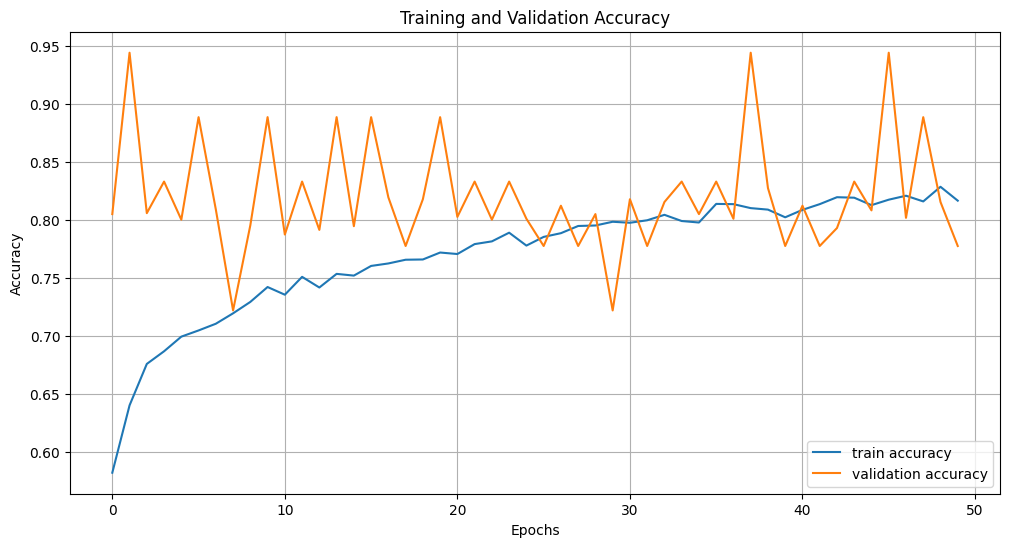

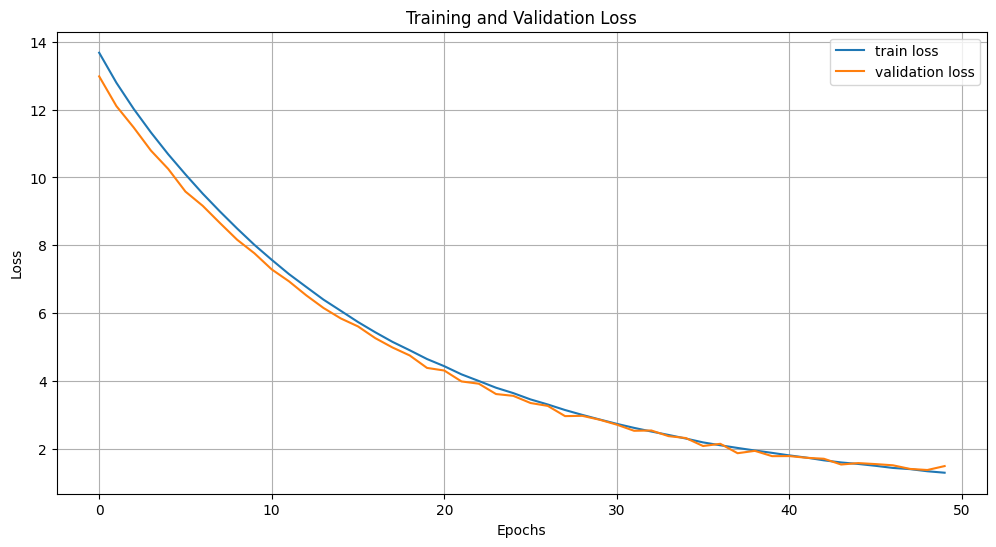

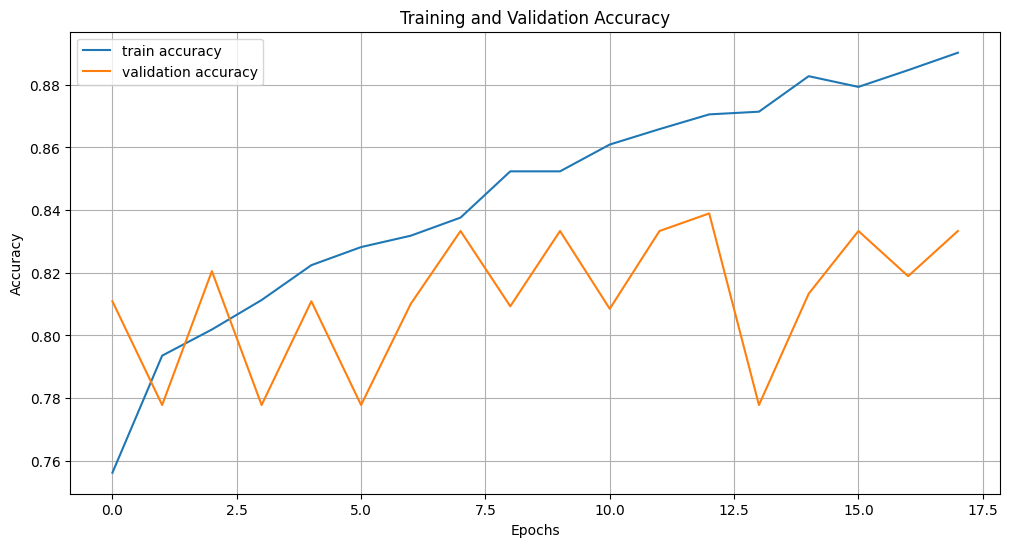

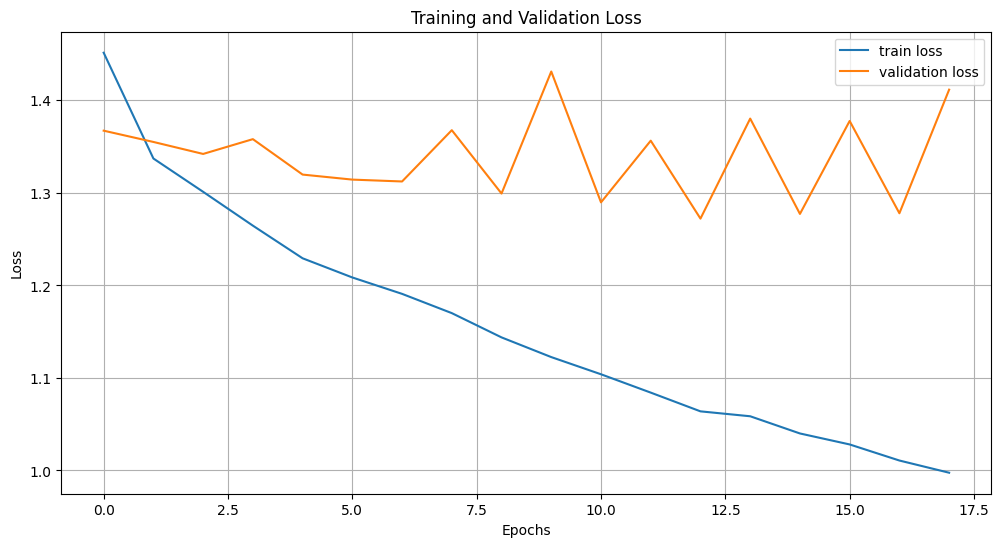

In [24]:
import matplotlib.pyplot as plt

def plot_training(history):
    # Plot training accuracy and validation accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.grid(True)
    plt.show()

    # Plot training loss and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.grid(True)
    plt.show()

# Assuming `history` is the history of your initial model training
# and `history_fine` is the history after fine-tuning

plot_training(history)  # Plot for the initial training
plot_training(history_fine)  # Plot for the fine-tuned model


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# Assuming `val_gen` is your validation generator and `model` is your trained model
# Make predictions on the validation data
y_pred_prob = model.predict(val_gen)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()  # Threshold at 0.5 for binary classification

# Get the true labels from the validation generator
y_true = np.concatenate([y for x, y in val_gen], axis=0).flatten()  # Flatten for compatibility

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(cm, display_labels=['Class 0', 'Class 1']).plot(cmap='Blues', ax=ax, colorbar=False)

# Add title and metrics to the plot
plt.title('Confusion Matrix with Metrics')
plt.xlabel(f'Predicted Labels\n\nPrecision: {precision:.2f} | Recall: {recall:.2f} | F1 Score: {f1:.2f}')
plt.ylabel('True Labels')
plt.show()



  18699/Unknown 649s 34ms/step

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Get the predicted probabilities
y_pred_prob = model.predict(val_gen).flatten()  # Flatten to a 1D array

# Get the true labels from the validation generator
y_true = np.concatenate([y for x, y in val_gen], axis=0).flatten()  # Flatten for compatibility

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_true, y_pred_prob)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



In [ ]:
# Visualize the network with keras visualizer
!pip3 install keras-visualizer
from keras_visualizer import visualizer
import matplotlib.image as mpimg
visualizer(model, file_format='png', view=True)
img = mpimg.imread('graph.png')
fig = plt.figure(figsize=[20,9])
plt.imshow(img)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs